In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from dfdjaxGP import JaxDerviativeGP

/Users/mikegros/opt/anaconda3/envs/jaxgp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n  = 20
pn = 50

x = np.random.rand(n)

y = np.exp(-x*2)*np.sin(x*2.*np.pi)

px = np.linspace(0,1,pn)
py = np.exp(-px*2)*np.sin(px*2.*np.pi)

# JaxDerivativeGP
### A class for using a Gaussian process to estimate an unknown function and do prediction with uncertainty on the function's derivatives


In [3]:
jgp = JaxDerviativeGP(x,y)
jgp.train()

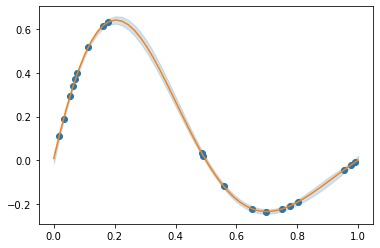

In [4]:
y_hat, _, upper, lower = jgp.predict(px)

plt.scatter(x, y,c="C0")
plt.plot(px, y_hat, c="C1")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()



## For prediction of derivatives with 1D GP:

- df/dx gives first derivative
- Higher derivatives checked by looking for int on last character
- so d2f/dx2 will give second derivative, as will df/dx2
- df/dx1 I think will give the same result as df/dx
- Cannot go higher than 9th derivative - computational cost will be impractical anyway, but also d10f/dx10 would get parsed as the 0th derivative because I'm currently looking only at the trailing int.
- 0th derivatives wont be properly processed either. Just leave derivative as None for predicting function values. 

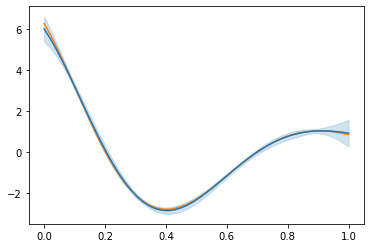

In [5]:
y_hat, _, upper, lower = jgp.predict(px, derivative="df/dx")

plt.plot(px, -2*np.exp(-2*px)*np.sin(px*2.*np.pi) + np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi, c="C1")
plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()


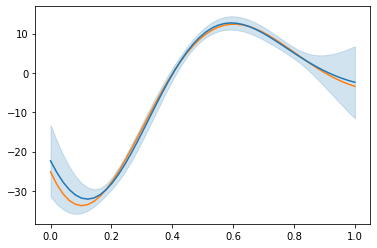

In [6]:
y_hat, _, upper, lower = jgp.predict(px, derivative="d2f/dx2")

plt.plot(px, 4*np.exp(-2*px)*np.sin(px*2.*np.pi) + 
         -4*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) + 
         -2*np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi - 
         np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2, c="C1")
plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()

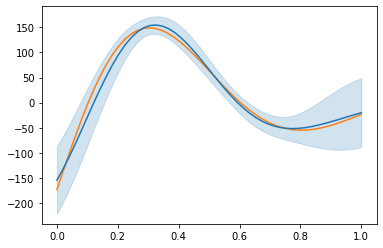

In [7]:
y_hat, _, upper, lower = jgp.predict(px, derivative="d3f/dx3")

plt.plot(px, -8*np.exp(-2*px)*np.sin(px*2.*np.pi) +
         8*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) +
         8*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) + 
         8*np.pi**2*np.exp(-2*px)*np.sin(px*2.*np.pi) + 
         4*np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi +
         2*np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2 + 
         2*np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2 +
         -np.exp(-2*px)*np.cos(px*2.*np.pi)*8*np.pi**3, c="C1")
plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()

In [8]:
def truef(x):
    return np.sin(x[:,0]*2 *np.pi) + x[:,1]

def truedfdx(x):
    #return -np.sin(x[:,0]*2 *np.pi)*4 *np.pi**2
    return np.cos(x[:,0]*2 *np.pi)*2 *np.pi

def truedfdy(x):
    #return 1.*np.zeros_like(x[:,0])
    return 1.*np.ones_like(x[:,0])


In [9]:
n  = 30
pn = 400

x  = np.random.rand(n,2)
px = np.array([(x, y) for x in np.linspace(0,1,20) for y in np.linspace(0,1,20)])
y  = truef(x)


In [10]:
jgp = JaxDerviativeGP(x,y)


In [11]:
jgp.train()

In [12]:
py   = truef(px)

vmin = np.min(py)
vmax = np.max(py)

y_hat, _, upper, lower = jgp.predict(px)

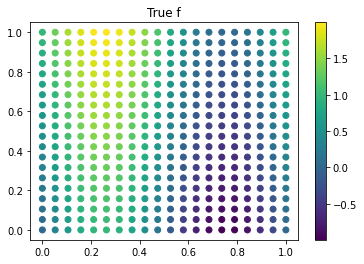

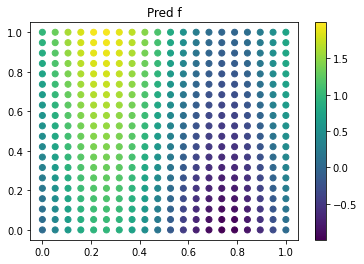

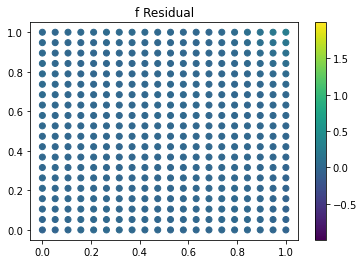

In [13]:
plt.scatter(px[:, 0], px[:, 1], c=py, vmin=vmin, vmax=vmax)
plt.title("True f")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=y_hat, vmin=vmin, vmax=vmax)
plt.title("Pred f")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=py - y_hat, vmin=vmin, vmax=vmax)
plt.title("f Residual")
plt.colorbar()
plt.show()


## For prediction of derivatives with 2D GP:

- df/dx, df/dy gives first derivative in x and y direction respectively
- As with 1D, higher derivatives checked by looking for int on last character
- Right now the implementation wont give mixed derivatives (e.g. ddf/dxdy or d3f/dx2dy, etc). This is mostly a bookkeeping thing with my code and should be do-able. If this is critical I can implement it sooner. 

Other cavaets on the 1D GP apply here

In [14]:
py   = truedfdx(px)

vmin = np.min(py)
vmax = np.max(py)

y_hat, _, upper, lower = jgp.predict(px, derivative="df/dx")

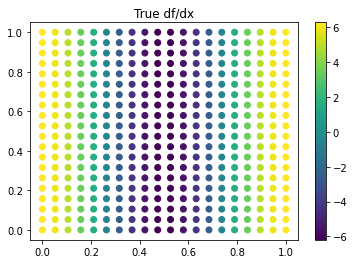

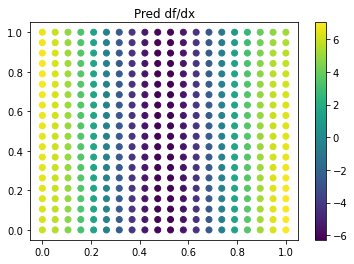

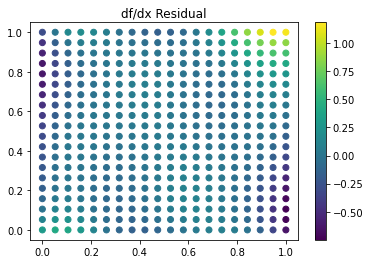

In [15]:
plt.scatter(px[:, 0], px[:, 1], c=py)
plt.title("True df/dx")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=y_hat)
plt.title("Pred df/dx")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c= py - y_hat)
plt.title("df/dx Residual")
plt.colorbar()
plt.show()


In [16]:
py   = truedfdy(px)

vmin = np.min(py)
vmax = np.max(py)

y_hat, _, upper, lower = jgp.predict(px, derivative="df/dy")

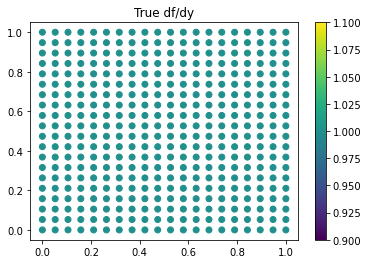

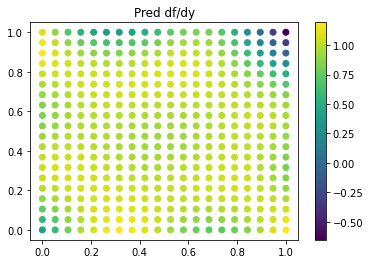

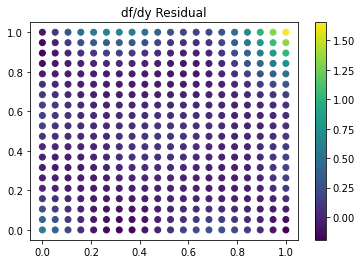

In [17]:
plt.scatter(px[:, 0], px[:, 1], c=py)
plt.title("True df/dy")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=y_hat)
plt.title("Pred df/dy")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=py - y_hat)
plt.title("df/dy Residual")
plt.colorbar()
plt.show()
